In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Leyendo los datos

In [2]:
df_ = pd.read_excel('./data/testdata.xlsx')
df_work = df_[1:][['Unnamed: 0','Unnamed: 1', 'Diego R.']]
df_work.columns = ['Px','Py','Z']

In [9]:
df_work = pd.read_excel('../linear_regression_distributed_optimization/data/testdata_dist.xlsx', header=None)
df_work.columns = ['Px','Py','Z']

In [10]:
df_work

,Px,Py,Z
0,-1.0,-1.00,-22.727454
1,-1.0,-0.98,-22.185502
2,-1.0,-0.96,-21.779524
3,-1.0,-0.94,-21.018529
4,-1.0,-0.92,-20.820209
...,...,...,...
10196,1.0,0.92,-30.292222
10197,1.0,0.94,-31.190132
10198,1.0,0.96,-31.972398
10199,1.0,0.98,-32.824494


### Gráfico de los puntos en el dataset

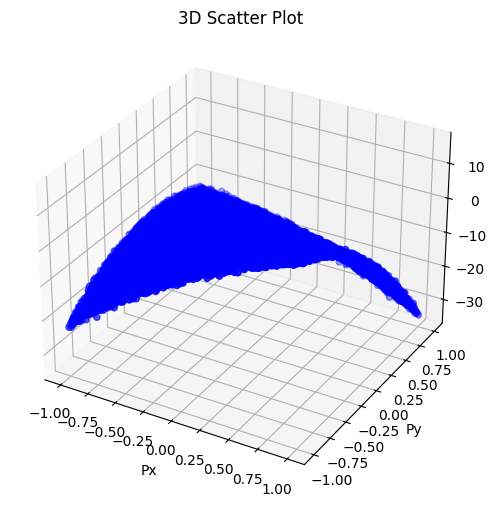

In [11]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_work['Px'], df_work['Py'], df_work['Z'], c='blue', marker='o')  # 'c' sets the color, 'marker' sets the marker style

# Set labels for the axes
ax.set_xlabel('Px')
ax.set_ylabel('Py')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('3D Scatter Plot')

plt.show()



El problema sugiere que deben ajustarse los paramentros $ \Theta = [a, b, C]$ (donde $a \in \mathbb{R}$, $b \in \mathbb{R}^{2}$, y $c \in \mathbb{R}^{2\times2}$) tal que se minimize la función de costo u objetivo $\epsilon$. O sea, se encuentre una función con coeficientes $\Theta$ que describa el plano dado por los puntos (en azul del gráfico de arriba) en el dataset.

Este proceso se le puede llamar ajuste de funciones paramétricas en donde se pretende ajustar una función paramétrica a una estructura de datos empíricos (dados por el dataset).

1. Así la función objetivo $\epsilon$ corresponde a la média de las distancias entre el estimador de $Z$, $\hat{Z}$ (dada por la función cuadrática) y $Z_{i}$. 

Pero antes, expresamos a $\hat{Z(\Theta, P_{i})}$ en su forma algebraica (y no matricial!), entonces:
 
   Si $\hat{Z(\Theta, P_{i})} = a + b^{T} \cdot P_{i} + P_{i}^T \cdot C \cdot P_{i}$

   y $b = \begin{bmatrix}    
                b_{1}\\ 
                b_{2}
                \end{bmatrix}$, $P_{i}^{T} = \begin{bmatrix}    
                b_{x_{i}}\\ 
                b_{y_{i}}
                \end{bmatrix}$ y $C = \begin{bmatrix}
        c_{11} \ c_{12} \\ 
        c_{21} \ c_{22}
        \end{bmatrix}$
   

   Al realizar las simplificaciones y factorizaciones correspondientes, tenemos que (forma algebraica):

   $\hat{Z(\Theta, P_{i})} = a + b_{1}P_{x_{i}} + b_{2}P_{y_{i}} +  (c_{12}+c_{21})P_{x_{i}}P_{y_{i}} + c_{11}P_{x_{i}}^{2} + c_{22}P_{y_{i}}^{2} $

   En este sentido, las variables de decisión son:  $\Theta = [a, \ b_{1}, \ b_{2}, \ c_{11}, \ c_{12}, \ c_{21}, \ c_{22}]$, donde para simplificar el cálculo de las derivadas parciales, podemos asumir que $c_{33} = (c_{12}+c_{21}) $, entonces tendriamos las variables de decisión  $\Theta = [a, \ b_{1}, \ b_{2}, \ c_{11}, \ c_{22}, \ c_{33}]$.

  $\hat{Z(\Theta, P_{i})} = a + b_{1}P_{x_{i}} + b_{2}P_{y_{i}} +  c_{33}P_{x_{i}}P_{y_{i}} + c_{11}P_{x_{i}}^{2} + c_{22}P_{y_{i}}^{2} $

   En principio no habrían restricciones, ya que no se específican explícitamente los intervalos en los cuales cada miembre de $\Theta$ tienen que operar, pero si se recomienda tener cuídado al momento de establecer los valores iniciales al momento de comenzar a calcular el gradiente descendiente ya que valores en orden mucho mayor al de los datos, pueden llevar a tomar más iteraciones para que el algoritmo de gradiente decendiente converga.

   



## 2. Cálculo del gradiente


Para el cálculo del gradiente, se debe recordar que la función de costo $\epsilon$, depende de $\hat{Z}$ y a su vez $\hat{Z}$ depende de $\Theta = [a, \ b_{1}, \ b_{2}, \ c_{11}, \ c_{22}]$. Por lo tanto, si queremos calcular las derivadas parciales de $\epsilon$ en función de cada una de las variables de decisión dentro de $\Theta$, debemos aplicar la regla de la cadena tal que nos permita representar la variación que $\Theta$ tiene sobre $\hat{Z}$, y consecuentemente la variación que $\hat{Z}$ tiene sobre $\epsilon$.

Para simplificar la implementación, asumimos a $\delta_{i}$ como se fuese la diferencia entre $\hat{Z_{i}}$ y $Z_{i}$ para cada punto $i$ ($\delta_{i} = (\hat{Z_{i}}-Z_{i})^{2}$) y a $\epsilon$ como la média de estos errores cuadráticos.

En este sentido, tenemos que:

$ \epsilon = \frac{1}{n} \sum_{i=0}^{n} (\hat{Z_{i}}-Z_{i})^{2} = \frac{1}{n} \sum_{i=0}^{n} \delta_{i}$

Entonces, si derivamos $\epsilon$ en función de $\hat{Z_{i}}$, se tendría el equivalente a esta expresión:

$\frac{\partial \epsilon}{\partial \Theta} = \frac{1}{n} \sum_{i=0}^{n} \frac{\partial \delta_{i}}{\partial \Theta}$

Esto facilita la implementación del gradiente descendente ya que solo vamos a necesitar calcular las derividas parciales de $\delta_{i}$ por cada punto $i$, para luego calcular su média aritmetica, que sería $\frac{\partial \epsilon}{\partial \Theta}$.



Entonces el proceso para calcular las derivadas parciales para cada $\delta_{i}$  (o solo $\delta$) se describe aplicando la regla de la cadena como se expresa abajo:


$\frac{\partial \delta}{\partial \Theta} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial \Theta}$

Si consideramos que 

$ \frac{\partial \delta}{\partial Z} = 2(\hat{Z_{i}} - Z_{i})$

Podemos tener el equivalente a derivar para cada uno de los elementos dentro de $\Theta$, como se muestra a continuación:


- (1) $\frac{\partial \delta}{\partial a} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial a}$
  
    $ \frac{\partial \delta}{\partial a}  = \frac{2}{n} (\hat{Z_{i}} - Z_{i}) (1) $  



- (2) $\frac{\partial \delta}{\partial b_{1}} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial b_{1}}$

    $\frac{\partial \delta}{\partial b_{1}}  = \frac{2}{n} (\hat{Z_{i}} - Z_{i}) (Px_{i}) $



- (3) $\frac{\partial \delta}{\partial b_{2}} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial b_{2}}$

    $\frac{\partial \delta}{\partial b_{1}}  = \frac{2}{n}(\hat{Z_{i}} - Z_{i}) (Px_{i}) $



- (4) $\frac{\partial \delta}{\partial c_{11}} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial c_{11}}$

    $\frac{\partial \delta}{\partial c_{11}}  = \frac{2}{n} (\hat{Z_{i}} - Z_{i}) (Px_{i}^{2}) $



- (5) $\frac{\partial \delta}{\partial c_{22}} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial c_{22}}$

    $\frac{\partial \delta}{\partial c_{22}}  = \frac{2}{n} (\hat{Z_{i}} - Z_{i}) (Py_{i}^{2}) $



- (6) $\frac{\partial \delta}{\partial c_{33}} = \frac{\partial \delta}{\partial Z}.\frac{\partial Z}{\partial c_{33}}$

    $\frac{\partial \delta}{\partial c_{33}}  = \frac{2}{n} (\hat{Z_{i}} - Z_{i}) (Px_{i}Py_{i}) $


**Nota:** También existe este material de soporte, en donde se resuelve el mismo problema aunque matricialmente: https://www.youtube.com/watch?v=EfsjEOb596Q


Una vez las el gradiente para cada punto $i$ se calcula, procedemos a promediarlas (como se expresó en la ecuación $\frac{\partial \epsilon}{\partial \Theta} = \frac{1}{n} \sum_{i=0}^{n} \frac{\partial \delta_{i}}{\partial \Theta}$ ) y ejecutamos el algoritmo de gradiente descendente como sigue a continuación


\For Para cada iteración: \
 \ \  Cálculo de las derivadas parciales (DESCRITO ANTERIORMENTE) \
 \ \ ... \
 \ \  $ a := a - \alpha \frac{\partial \epsilon}{\partial a}$ \
 \ \  $ b1 := b1 - \alpha \frac{\partial \epsilon}{\partial b1}$ \
 \ \  $ b2 := b2 - \alpha \frac{\partial \epsilon}{\partial b2}$ \
 \ \  $ c11 := c11 - \alpha \frac{\partial \epsilon}{\partial c11}$ \
 \ \  $ c22 := c22 - \alpha \frac{\partial \epsilon}{\partial c22}$ \
 \ \  $ c33 := c33 - \alpha \frac{\partial \epsilon}{\partial c33}$ \
\retornar a, b1, b2, c11, c22,c 33

Así, el objetivo del algoritmo es actualizar los coeficientes o variables de decisión de $\hat{Z}$ en la dirección del descenso que cada derivada parcial indica a cada iteración, multiplicado por $\alpha$ o la taza de aprendizaje, que es esocgida arbritariamente.

In [12]:
# Definición del método para la expresión de Z
def get_z(px_i, py_i, a, b_1, b_2, c_11, c_22, c_33):
    _z = a + b_1*px_i + b_2*py_i  + c_33*px_i*py_i + c_11*(px_i**2) + c_22*(py_i**2)
    return _z

# Implementación del algoritmo del gradiente descendente: Referencia, curso de Andrew NG de deep learning y https://www.youtube.com/watch?v=EfsjEOb596Q&t=836s
def gradient_descent(df, num_iterations, alpha = 0.001):

    # init coef. aleatoriamente
    s = np.random.uniform(-5,5,6)
    a = s[0]
    b1 = s[1]
    b2 = s[2]
    c11 = s[3]
    c22 = s[4]
    c33 = s[5]

    dj_da, dj_db1, dj_db2, dj_dc11, dj_dc22, dj_dc33 = 0,0,0,0,0,0
    for it in range(num_iterations):
        # derivatives
        for P in df[['Px', 'Py', 'Z']].values:
            px_i = P[0]
            py_i = P[1]
            Z = P[2]
            # delta calculus
            z_hat_ = get_z(px_i, py_i, a, b1, b2, c11, c22, c33)
            dj_dz = 2*(z_hat_-Z)
            dj_da += dj_dz*1
            dj_db1 += dj_dz*px_i
            dj_db2 += dj_dz*py_i
            dj_dc11 += dj_dz*(px_i**2)
            dj_dc22 += dj_dz*(py_i**2)
            dj_dc33 += dj_dz*(px_i*py_i)
        
        n = len(df)
        dj_da = dj_da/n
        dj_db1 = dj_db1/n
        dj_db2 = dj_db2/n
        dj_dc11 = dj_dc22/n
        dj_dc22 = dj_dc22/n
        dj_dc33 = dj_dc33/n

        # actualizaciones de los coeficientes conforme la dirección que indica cada derivada parcial
        a = a - alpha*dj_da
        b1 = b1 - alpha*dj_db1
        b2 = b2 - alpha*dj_db2
        c11 = c11 - alpha*dj_dc11
        c22 = c22 - alpha*dj_dc22
        c33 = c33 - alpha*dj_dc33

    # coeficientes
    return {'a':a, 'b1':b1, 'b2': b2, 'c11': c11, 'c22': c22, 'c33': c33}
    

In [13]:
# ejecución del algoritmo de gradiente descendiente, los coeficientes finales se guardan en el diccionario opt
opt= gradient_descent(df_work, 5000, 0.01)

# con los coeficientes calculados por la optimización, se calcula la proyección de la función z_hat_ 
z_hat_ = df_work.apply(lambda row: get_z(row['Px'], row['Py'], opt['a'], opt['b1'], opt['b2'], opt['c11'], opt['c22'], opt['c33']), axis = 1)

print('Coeficientes:')
opt

Coeficientes:


{'a': 0.38384134454940944,
 'b1': 4.400952269628543,
 'b2': -10.004586303933388,
 'c11': -9.955915006148453,
 'c22': -8.165624011027246,
 'c33': -14.120656161635381}

In [14]:
!pwd

/Users/pecalvache/Documents/dynamic_optimization/gradient_descent_from_scratch


Por facilidad, se deciden hacer 25000 iteraciones, tal que el chance de convergencia del gradiente sea mayor, y se selecciona un $alpha$ de 0.01.

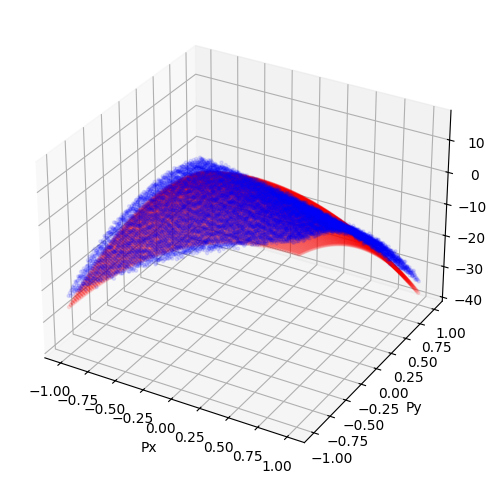

In [15]:
# Gráfico de z_hat_ (función con los coeficientes calculados) vs z (variables del dataset)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_work['Px'], df_work['Py'], df_work['Z'], c='blue', marker='.', alpha = 0.1)  # 'c' sets the color, 'marker' sets the marker style
ax.scatter(df_work['Px'], df_work['Py'], z_hat_, c='red', marker='.', alpha = 0.1)  # 'c' sets the color, 'marker' sets the marker style

ax.set_xlabel('Px')
ax.set_ylabel('Py')
ax.set_zlabel('Z')


plt.show()



### Comparando con una función z_hat_ con coeficientes aleatórios:

Si los coeficientes son inicializados de manera aleatória, vemos que el ajuste entre la figura roja (z_hat_) y la azul (z real o del dataset) es bastante pobre COMO SE VE A CONTINUACIÓN:

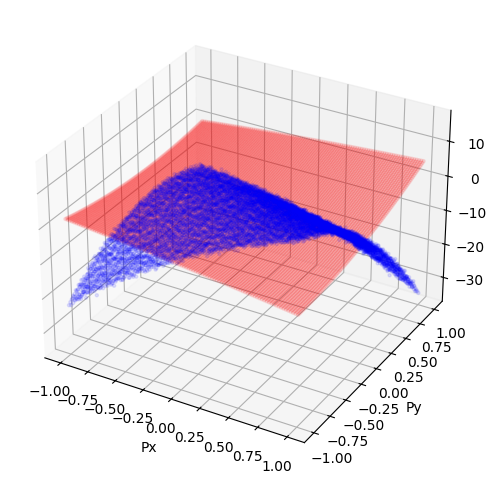

In [17]:


s = np.random.uniform(-5,5,6)
a = s[0]
b1 = s[1]
b2 = s[2]
c11 = s[3]
c22 = s[4]
c33 = s[5]

z_hat_ = df_work.apply(lambda row: get_z(row['Px'], row['Py'], a, b1, b2, c11, c22, c33), axis = 1)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_work['Px'], df_work['Py'], df_work['Z'], c='blue', marker='.', alpha = 0.1)  # 'c' sets the color, 'marker' sets the marker style
ax.scatter(df_work['Px'], df_work['Py'], z_hat_, c='red',marker='.', alpha = 0.1)  # 'c' sets the color, 'marker' sets the marker style

ax.set_xlabel('Px')
ax.set_ylabel('Py')
ax.set_zlabel('Z')

plt.show()